In [2]:
import os
import glob
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple
from PSSimPy.simulator import ABMSim
from PSSimPy import Bank
from PSSimPy.utils import add_minutes_to_time

# Set Up Strategic Behavior

## Original Intrady Liquidity Game

In [3]:
# state: s = (t, b, β, ω, E)
MDPState = namedtuple("MDPState", [
    "t", 
    "balance", 
    "borrowed", 
    "obligations", 
    "expected_inbound"
])

In [4]:
class OriMDPSearch:
    """
    MDP formulation for the focal player's decision in an n-player Intraday Liquidity Game.
    
    State: s = (t, b, β, ω, E), where:
      - t: current period,
      - b: focal player's balance,
      - β: focal player's borrowed amount,
      - ω: focal player's outstanding obligations,
      - E: aggregate expected inbound payment from the n-1 opponents, 
           given by E_t = (n-1)p_tz^*.
    
    Here, p_t is the probability that an obligation arises (per opponent) in period t.
    If an obligation arises, opponents pay the focal player if their dominant strategy is to pay,
    which (with tie → pay) implies z^* = 1 when γ ≤ δ, and 0 when γ > δ.
    Under pure rational expectations (i.e., with ζ = 0), agents do not update their expectations.
    
    The focal player has two strategies:
      0 = Delay: incur delay cost δ per unit of obligation; obligations carry forward.
      1 = Pay: if b < ω, borrow the shortfall at cost γ per unit; clear obligations;
           any excess balance repays borrowing.
           
    The focal player also pays a carry cost of γ·β each period.
    
    We solve the MDP via depth-limited dynamic programming, reflecting bounded rationality.
    """
    
    def __init__(self, 
                 n_players=4,
                 n_periods=4, 
                 p_t=0.8,      # probability an obligation arises per opponent in a period
                 delta=0.2, 
                 gamma=0.1,
                 zeta=0.0,     # learning rate, set to 0 for pure RE
                 seed=42):
        """
        n_players   : total players (focal + opponents)
        n_periods   : horizon for the MDP
        p_t         : probability an obligation arises per opponent
        delta       : per-unit delay cost
        gamma       : cost for borrowing and carrying borrowed funds
        zeta        : learning rate for updating expectations (set to 0 for pure RE)
        seed        : random seed for reproducibility
        """
        random.seed(seed)
        self.n_players = n_players
        self.n_periods = n_periods
        self.p_t = p_t
        self.delta = delta
        self.gamma = gamma
        self.zeta = zeta  # with zeta=0, no updating occurs
        # Dominant strategy assumption: if γ ≤ δ then opponents pay, i.e., z^*=1; otherwise, z^*=0.
        self.z_star = 1.0 if self.gamma <= self.delta else 0.0

    def initial_state(self):
        """
        The initial state: the focal player's balance, borrowed, and obligations are zero.
        The initial aggregate expected inbound is:
           E₀ = (n_players - 1) * p_t * z_star.
        """
        E0 = (self.n_players - 1) * self.p_t * self.z_star
        return MDPState(
            t=0,
            balance=0.0,
            borrowed=0.0,
            obligations=0.0,
            expected_inbound=E0
        )

    def carry_cost(self, borrowed):
        """Cost for carrying borrowed funds over one period."""
        return self.gamma * borrowed if borrowed > 0 else 0.0

    def transition_function(self, state, action):
        """
        Given state s = (t, b, β, ω, E) and focal action a ∈ {0,1},
        return a list of (next_state, probability, immediate_cost).
        
        Here, we assume that in each period, every opponent independently generates an obligation 
        with probability p_t, so that on average, (n_players - 1)*p_t obligations arrive.
        For simplicity, we assume that the number of new obligations is exactly (n-1)p_t.
        
        The focal player's balance is increased by the aggregate expected inbound E,
        and then the chosen action is applied:
         - If a = 1 (Pay): if b + E < ω + (n-1)p_t, the focal borrows the shortfall (cost = γ*(shortfall)); 
           obligations clear.
         - If a = 0 (Delay): cost = δ times the total obligations.
        In both cases, a carry cost γβ is added.
        """
        if state.t >= self.n_periods:
            return [(state, 1.0, 0.0)]
        
        # Compute carry cost
        cost_carry = self.carry_cost(state.borrowed)
        # Inbound: focal's balance increases by E
        mid_balance = state.balance + state.expected_inbound
        # New obligations: exactly (n-1)p_t arrive
        new_arrivals = (self.n_players - 1) * self.p_t
        new_oblig = state.obligations + new_arrivals

        if action == 1:  # Pay
            shortfall = max(0.0, new_oblig - mid_balance)
            cost_borrow = self.gamma * shortfall if shortfall > 0 else 0.0

            new_balance = mid_balance
            new_borrowed = state.borrowed
            if shortfall > 0:
                new_balance = 0.0
                new_borrowed += shortfall
                new_oblig_after = 0.0
            else:
                new_balance = mid_balance - new_oblig
                new_oblig_after = 0.0

            if new_balance > 0 and new_borrowed > 0:
                repay = min(new_balance, new_borrowed)
                new_borrowed -= repay
                new_balance -= repay

            immediate_cost = cost_carry + cost_borrow
            next_state = MDPState(
                t=state.t + 1,
                balance=new_balance,
                borrowed=new_borrowed,
                obligations=new_oblig_after,
                expected_inbound=state.expected_inbound  # under pure RE, remains constant
            )
            return [(next_state, 1.0, immediate_cost)]
        else:  # Delay
            cost_delay = self.delta * new_oblig
            immediate_cost = cost_carry + cost_delay
            next_state = MDPState(
                t=state.t + 1,
                balance=mid_balance,
                borrowed=state.borrowed,
                obligations=new_oblig,
                expected_inbound=state.expected_inbound
            )
            return [(next_state, 1.0, immediate_cost)]

    def actions(self, state):
        """Return the focal player's actions: 0 = Delay, 1 = Pay."""
        return [0, 1]

    def state_to_key(self, state):
        """Convert state into a hashable tuple for memoization."""
        return (state.t, round(state.balance,4), round(state.borrowed,4),
                round(state.obligations,4), round(state.expected_inbound,4))

    def depth_limited_value(self, state, depth, memo=None):
        """
        Depth-limited lookahead from state up to 'depth' periods.
        Returns (best_value, best_action) where best_value is the maximum expected reward 
        (i.e., negative total cost) and best_action ∈ {0,1}.
        
        This recursive algorithm uses memoization. The limited depth represents the 
        bounded rationality of the focal player in forming its rational expectation.
        """
        if memo is None:
            memo = {}
        if depth <= 0 or state.t >= self.n_periods:
            return (0.0, None)
        key = (self.state_to_key(state), depth)
        if key in memo:
            return memo[key]
        best_value = float('-inf')
        best_action = None
        for a in self.actions(state):
            transitions = self.transition_function(state, a)
            total_val = 0.0
            for (ns, prob, cost) in transitions:
                immediate_reward = -cost  # cost is a negative reward
                future_val, _ = self.depth_limited_value(ns, depth - 1, memo)
                total_val += prob * (immediate_reward + future_val)
            if total_val > best_value:
                best_value = total_val
                best_action = a
        memo[key] = (best_value, best_action)
        return memo[key]

    def update_current_state(self, current_state, focal_action, partial_observations):
        """
        Update the current state based on the focal player's chosen action and partial observations.
        
        partial_observations is a dictionary containing:
          - "inbound_payments": actual inbound payment received,
          - "arrived_obligations": number of new obligations that actually arrived,
          - "observed_expected": observed aggregate inbound (e.g., from opponents).
        
        Under our pure rational expectations assumption (with ζ = 0), the aggregate expectation
        remains fixed as E_t = (n-1)p_tz^*. However, to allow for potential deviations, we include 
        an update rule:
        
          E' = ζ · (observed_expected) + (1 - ζ) · E.
          
        Setting ζ = 0 recovers the pure RE case.
        
        Returns the updated state s' = (t+1, b', β', ω', E').
        """
        observed_inbound = partial_observations.get("inbound_payments", 0.0)
        new_balance_pre = current_state.balance + observed_inbound
        arrived = partial_observations.get("arrived_obligations", 0)
        new_obligations = current_state.obligations + arrived
        observed_expected = partial_observations.get("observed_expected", current_state.expected_inbound)
        new_expected = self.zeta * observed_expected + (1 - self.zeta) * current_state.expected_inbound

        if focal_action == 1:  # Pay
            shortfall = max(0.0, new_obligations - new_balance_pre)
            new_borrowed = current_state.borrowed + shortfall
            if shortfall > 0:
                new_balance = 0.0
                new_oblig_after = 0.0
            else:
                new_balance = new_balance_pre - new_obligations
                new_oblig_after = 0.0
            if new_balance > 0 and new_borrowed > 0:
                repay = min(new_balance, new_borrowed)
                new_borrowed -= repay
                new_balance -= repay
            next_state = MDPState(
                t=current_state.t + 1,
                balance=new_balance,
                borrowed=new_borrowed,
                obligations=new_oblig_after,
                expected_inbound=new_expected
            )
            return next_state
        else:  # Delay
            next_state = MDPState(
                t=current_state.t + 1,
                balance=new_balance_pre,
                borrowed=current_state.borrowed,
                obligations=new_obligations,
                expected_inbound=new_expected
            )
            return next_state

In [46]:
# Smoke test
n_periods = 10
n_players = 10
p_t = 0.8
mdp = OriMDPSearch(
    n_players=n_players,
    n_periods=n_periods,
    p_t=p_t,
    delta=0.3,
    gamma=0.2,
    seed=1000
)

init_state = mdp.initial_state()
print("Initial state:", init_state)
next_state = init_state

while n_periods > 0:
    best_val, best_act = mdp.depth_limited_value(next_state, depth=n_periods)
    print(f"Best value = {best_val:.2f}, best action = {'DELAY' if best_act==0 else 'PAY'}")

    # actual partial observations
    inbound_payments = sum([1 if random.uniform(0.0, 1.0) <= p_t else 0 for _ in range(n_players - 1)])
    arrived_obligations = sum([1 if random.uniform(0.0, 1.0) <= p_t else 0 for _ in range(n_players - 1)])
    partial_obs = {
        "inbound_payments": inbound_payments,
        "arrived_obligations": arrived_obligations,
        "observed_expected": 0.75 # not important
    }

    # next state
    next_state = mdp.update_current_state(next_state, best_act, partial_obs)
    print("Updated state after partial observations and chosen action:", next_state)

    n_periods -= 1

Initial state: MDPState(t=0, balance=0.0, borrowed=0.0, obligations=0.0, expected_inbound=7.2)
Best value = 0.00, best action = PAY
Updated state after partial observations and chosen action: MDPState(t=1, balance=0.0, borrowed=0.0, obligations=0.0, expected_inbound=7.2)
Best value = 0.00, best action = PAY
Updated state after partial observations and chosen action: MDPState(t=2, balance=0.0, borrowed=2.0, obligations=0.0, expected_inbound=7.2)
Best value = -3.20, best action = PAY
Updated state after partial observations and chosen action: MDPState(t=3, balance=1.0, borrowed=0.0, obligations=0.0, expected_inbound=7.2)
Best value = 0.00, best action = PAY
Updated state after partial observations and chosen action: MDPState(t=4, balance=0.0, borrowed=0.0, obligations=0.0, expected_inbound=7.2)
Best value = 0.00, best action = PAY
Updated state after partial observations and chosen action: MDPState(t=5, balance=1.0, borrowed=0.0, obligations=0.0, expected_inbound=7.2)
Best value = 0.00, 

In [6]:
mdp = OriMDPSearch(
    n_players=n_players,
    n_periods=n_periods,
    p_t=0.8, # to be defined as a global variable
    delta=0.2, # to be defined as a global variable
    gamma=0.3, # to be defined as a global variable
    seed=42
)

# Set up strategic bank agent
class OriStrategicBank(Bank):

    def __init__(self, name, strategy_type='OriStrategic', **kwargs):
        super().__init__(name, strategy_type, **kwargs)
        self.mdp_state = mdp.initial_state() # mdp needs to be redefined before each simulation run
        self.mdp_previous_action = 0
        self.n_periods = 10
    
    # overwrite strategy
    def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
        if len(txns_to_settle) == 0:
            return set()
        else:
            # we assume 1:1 mapping of bank to account so we can just extract any txn and use that account
            txn = txns_to_settle.copy().pop()
            bank_account = txn.sender_account

        if current_time == "08:00":
            pass
        else:
            # calculate actual inbound payments from previous period
            previous_time = add_minutes_to_time(current_time, -15)
            df_processed_txns = pd.read_csv(f'{sim_name}-processed_transactions.csv')
            filtered_df = df_processed_txns[(df_processed_txns['to_account'] == bank_account) & 
                    (df_processed_txns['settlement_time'] == previous_time)]
            inbound_payments = filtered_df['amount'].sum()

            # calculate amount of obligations that arrived in this period
            arrived_obligations = sum([txn.amount for txn in txns_to_settle if txn.arrival_time == current_time])

            partial_obs = {
                "inbound_payments": inbound_payments,
                "arrived_obligations": arrived_obligations,
                "observed_expected": 0.75 # not important
            }

            self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)

        _, best_act = mdp.depth_limited_value(self.mdp_state, depth=self.n_periods)
        self.n_periods -= 1
        self.mdp_previous_action = best_act

        if best_act == 1:
            return txns_to_settle
        else:
            return set()
        

In [7]:
class RandomBank(Bank):
    def __init__(self, name, strategy_type='OriStrategic', **kwargs):
        super().__init__(name, strategy_type, **kwargs)

    # overwrite strategy
    def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
        r = random.randint(0, 1)
        if r == 1:
            return txns_to_settle
        else:
            return set()

# Calculation functions

In [8]:
def calculate_delay_cost(sim_name, account: str, delta: float):
    df_processed_txns = pd.read_csv(f"{sim_name}-processed_transactions.csv")

    # Filter transactions for the given account
    relevant_txns = df_processed_txns[df_processed_txns['from_account'] == account]
    
    # Initialize total delay cost
    total_delay_cost = 0
    
    # Calculate delay cost for each transaction
    for _, row in relevant_txns.iterrows():
        # Extract submission_time and time as datetime objects
        submission_time = pd.to_datetime(row['submission_time'])
        txn_time = pd.to_datetime(row['time'])
        
        # Calculate the delay in minutes (convert Timedelta to minutes)
        delay_minutes = (submission_time - txn_time).total_seconds() / 60
        
        # Calculate the delay cost
        delay_cost = (delay_minutes / 15) * delta
        
        # Accumulate the delay cost
        total_delay_cost += delay_cost
    
    return total_delay_cost

In [9]:
def calculate_borrowing_cost(sim_name, account: str, gamma: float):
    df_credit_facility = pd.read_csv(f'{sim_name}-credit_facility.csv')
    
    # Filter for the given account
    relevant_credit = df_credit_facility[df_credit_facility['account'] == account]

    # Initialize total borrowing cost
    total_borrowing_cost = 0

    # Calculate borrowing cost at each period
    for _, row in relevant_credit.iterrows():
        borrowed_amount = row['total_credit']
        borrowing_cost = borrowed_amount * gamma
        total_borrowing_cost += borrowing_cost
    
    return total_borrowing_cost

# Simulation

In [10]:
banks = pd.read_csv('data_input/bank_template_with_strategy.csv')
accounts = pd.read_csv('data_input/account_template_with_collateral.csv')

strategy_mapping = {'OriStrategic': OriStrategicBank, 'Random': RandomBank}

sim = ABMSim(name='test_sim', banks=banks, accounts=accounts, strategy_mapping=strategy_mapping, open_time='08:00', close_time='10:30', eod_force_settlement=True, txn_arrival_prob=0.8, txn_amount_range=(1,1))
sim.run()

## Original Game - Strategic vs Not Strategic

#### Functions

In [ ]:
def simulate_original_game(p_t: float, delta: float, gamma: float, seed: int, strategic: bool, focal_account='acc3'):
    mdp = OriMDPSearch(
        n_players=10,
        n_periods=10,
        p_t=p_t, # to be defined as a global variable
        delta=delta, # to be defined as a global variable
        gamma=gamma, # to be defined as a global variable
        seed=seed
    )
            

    # strategic play
    if strategic:
        banks = pd.read_csv('data_input/bank_template_with_strategy.csv')
    else:
        banks = pd.read_csv('data_input/bank_template_with_strategy_1.csv')
    accounts = pd.read_csv('data_input/account_template_with_collateral.csv')
    sim_name = 'test_sim'
    sim = ABMSim(name=sim_name, banks=banks, accounts=accounts, strategy_mapping=strategy_mapping, open_time='08:00', close_time='10:30', eod_force_settlement=True, txn_arrival_prob=0.8, txn_amount_range=(1,1))
    sim.run()
    
    # extract costs
    delay_costs = {}
    borrowing_costs = {}
    for account in accounts['id'].tolist():
        delay_costs[account] = calculate_delay_cost(sim_name, account, delta)
        borrowing_costs[account] = calculate_borrowing_cost(sim_name, account, gamma)

    # tear down
    # Remove each .csv file
    csv_files = glob.glob("*.csv")
    for file in csv_files:
        os.remove(file)

    return delay_costs[focal_account] + borrowing_costs[focal_account]

In [12]:
def visualize_costs(total_costs_1: list, total_costs_2: list, label_1="Scenario 1", label_2="Scenario 2"):
    # Convert to numpy arrays
    costs_1 = np.array(total_costs_1)
    costs_2 = np.array(total_costs_2)

    # Compute summary statistics
    mean_cost_1 = np.mean(costs_1)
    median_cost_1 = np.median(costs_1)
    std_cost_1 = np.std(costs_1)
    
    mean_cost_2 = np.mean(costs_2)
    median_cost_2 = np.median(costs_2)
    std_cost_2 = np.std(costs_2)
    
    print(f"{label_1}:")
    print("Mean total cost:", mean_cost_1)
    print("Median total cost:", median_cost_1)
    print("Standard Deviation:", std_cost_1)
    print("")

    print(f"{label_2}:")
    print("Mean total cost:", mean_cost_2)
    print("Median total cost:", median_cost_2)
    print("Standard Deviation:", std_cost_2)
    print("")

    # Plot histograms
    plt.figure(figsize=(8,6))
    plt.hist(costs_1, bins='auto', density=True, alpha=0.5, color='blue', edgecolor='black', label=label_1)
    plt.hist(costs_2, bins='auto', density=True, alpha=0.5, color='orange', edgecolor='black', label=label_2)

    # Overlay the mean and median as vertical lines
    plt.axvline(mean_cost_1, color='blue', linestyle='dashed', linewidth=2, label=f'{label_1} Mean: {mean_cost_1:.2f}')
    plt.axvline(median_cost_1, color='blue', linestyle='dotted', linewidth=2, label=f'{label_1} Median: {median_cost_1:.2f}')
    
    plt.axvline(mean_cost_2, color='orange', linestyle='dashed', linewidth=2, label=f'{label_2} Mean: {mean_cost_2:.2f}')
    plt.axvline(median_cost_2, color='orange', linestyle='dotted', linewidth=2, label=f'{label_2} Median: {median_cost_2:.2f}')

    plt.title('Comparison of Total Cost Distributions')
    plt.xlabel('Total Cost')
    plt.ylabel('Density')
    plt.legend()

    plt.show()


#### Delay Costs > Borrowing Costs

In [38]:
p_t = 0.8
delta = 0.3
gamma = 0.2
n_simulations = 100

In [ ]:
total_costs_strategic = []
total_costs_non_strategic = []

for sim_seed in range(1000, 1000 + n_simulations):
    random.seed(sim_seed)
    np.random.seed(sim_seed)
    
    total_cost_strategic = simulate_original_game(p_t, delta, gamma, sim_seed, True)
    total_costs_strategic.append(total_cost_strategic)

    total_cost_non_strategic = simulate_original_game(p_t, delta, gamma, sim_seed, False)
    total_costs_non_strategic.append(total_cost_non_strategic)

Strategic:
Mean total cost: 30.18
Median total cost: 29.2
Standard Deviation: 5.984680442596748

Non-Strategic:
Mean total cost: 8.202000000000002
Median total cost: 8.0
Standard Deviation: 2.725214853915192



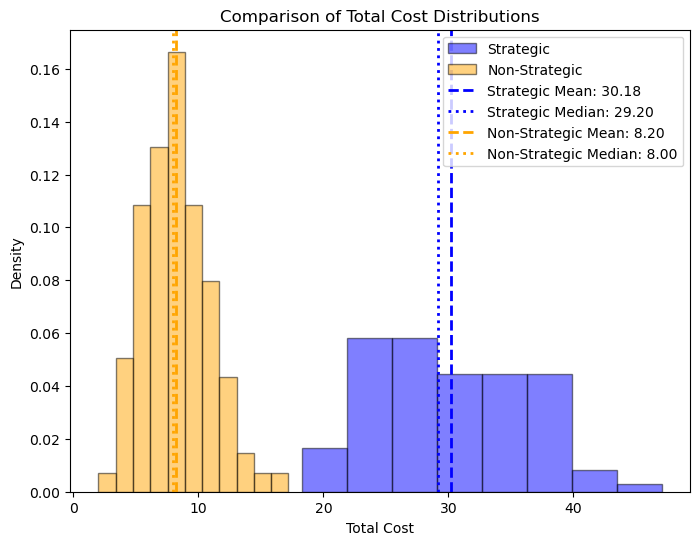

In [43]:
visualize_costs(total_costs_strategic, total_costs_non_strategic, 'Strategic', 'Non-Strategic')

#### Delay Costs < Borrowing Costs

In [35]:
p_t = 0.8
delta = 0.2
gamma = 0.3
n_simulations = 100

In [36]:
total_costs_strategic = []
total_costs_non_strategic = []

for sim_seed in range(1000, 1000 + n_simulations):
    random.seed(sim_seed)
    total_cost_strategic = simulate_original_game(p_t, delta, gamma, sim_seed, True)
    total_costs_strategic.append(total_cost_strategic)

    total_cost_non_strategic = simulate_original_game(p_t, delta, gamma, sim_seed, False)
    total_costs_non_strategic.append(total_cost_non_strategic)

Strategic:
Mean total cost: 23.748000000000005
Median total cost: 21.0
Standard Deviation: 7.299896985574523

Non-Strategic:
Mean total cost: 13.026000000000002
Median total cost: 12.900000000000002
Standard Deviation: 4.860218513606153



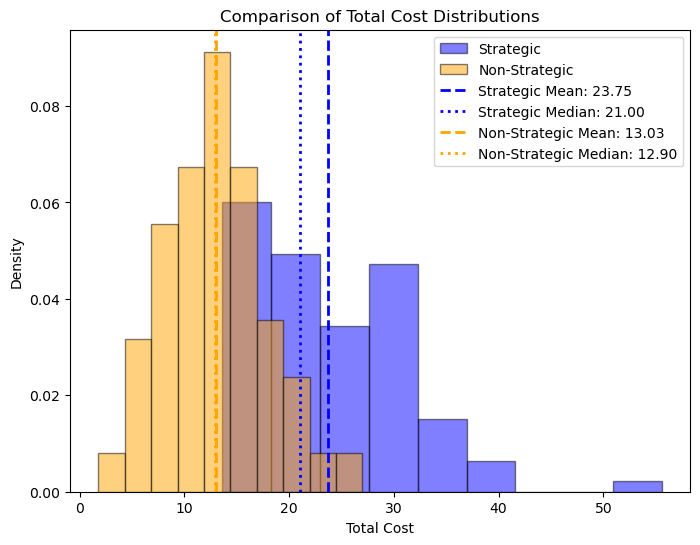

In [37]:
visualize_costs(total_costs_strategic, total_costs_non_strategic, 'Strategic', 'Non-Strategic')